# Assignment-1

**Due Date:** 15.11.2023

---------------------------------------

**Instructor:** Ali Seydi KEÇELİ

**TA:** Görkem Akyıldız

---------------------------------------
**Student Name Surname**: Melike Nur DULKADİR
**Student ID**: 21992919

## PART 1: Dimensionality Reduction with PCA

This assignment comprises three key components, each designed to foster familiarity with image representation and processing. In the first part, participants will implement and analyze a dimension reduction algorithm, specifically employing covariance matrix-based PCA to represent images in lower dimensions. The second segment involves the implementation of a simple image retrieval algorithm with different representations. Finally, the third part focuses on implementing a classification algorithm based on logistic regression. Together, these exercises aim to provide a comprehensive understanding of image processing, covering dimension reduction, image retrieval, and classification using machine learning techniques.

In [1]:
# Importing necessary libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

Image loading function that reads images from a specified folder, converts them to NumPy arrays, flattens them, and compiles them into a list.

In [2]:
def load_image_data(dataset_folder):
    image_data = []
    for filename in os.listdir(dataset_folder):
        image_path = os.path.join(dataset_folder, filename)
        img = Image.open(image_path)
        if img is not None:
            img_array = np.array(img)
            # Use intensity values as feature of corresponding image --> each image's shape = 1 x 65536
            image_data.append(img_array.flatten())
    return image_data

This function normalizes a set of images by subtracting the mean intensity value from each pixel in every image and returns the normalized images as flattened arrays.

In [3]:
def normalize_images(M):
    normalized_images = []
    for img_arr in M:
        mean_vec = np.mean(img_arr)
        normalized_img_arr = img_arr - mean_vec
        normalized_images.append(normalized_img_arr.flatten())
    return normalized_images

This function computes the eigenvalues and corresponding eigenvectors of a given covariance matrix, sorting them in descending order based on eigenvalues. The sorted eigenvectors and eigenvalues are then returned.

In [4]:
def sorted_eigenvalue_eigenvectors(cov):
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    return sorted_eigenvectors, sorted_eigenvalues


This function performs Principal Component Analysis (PCA) on a dataset of images, projecting them into a reduced-dimensional space specified by 'n' and returning the projected images along with the sorted eigenvalues.

In [5]:
def apply_pca(n,image_data):
    # Representing the dataset with a matrix, M , that has a shape 65536x11
    M = np.column_stack(image_data)
    
    # Normalized 65536x11 shaped matrix is called D.
    normalized_images = normalize_images(M.T)
    D = np.column_stack(normalized_images)
    
    # 11x11 covariance matrix
    Cov = np.cov(D, rowvar=False)
    
    # Sorting eigenvectors according to their corresponding eigenvalues (in descending order). Choosing the first n eigenvectors among them and naming it as S
    sorted_eigenvectors, sorted_eigenvalues = sorted_eigenvalue_eigenvectors(Cov)
    S = sorted_eigenvectors[:, :n]

    # Applying D@S and naming it as I 
    I = D @ S
    
    # Project all images to the lower dimensional space
    projected_images = I.T @ D
    
    return projected_images, sorted_eigenvalues


These lines load images from "Dataset1," apply PCA with a dimensionality of 3, and store the projected images and sorted eigenvalues.

In [6]:
dataset_folder = "Dataset1"
image_data = load_image_data(dataset_folder)
projected_images, sorted_eigenvalues = apply_pca(3,image_data)

This code generates a visualization with original images on the top row and their projections onto the first three principal components on the bottom row.

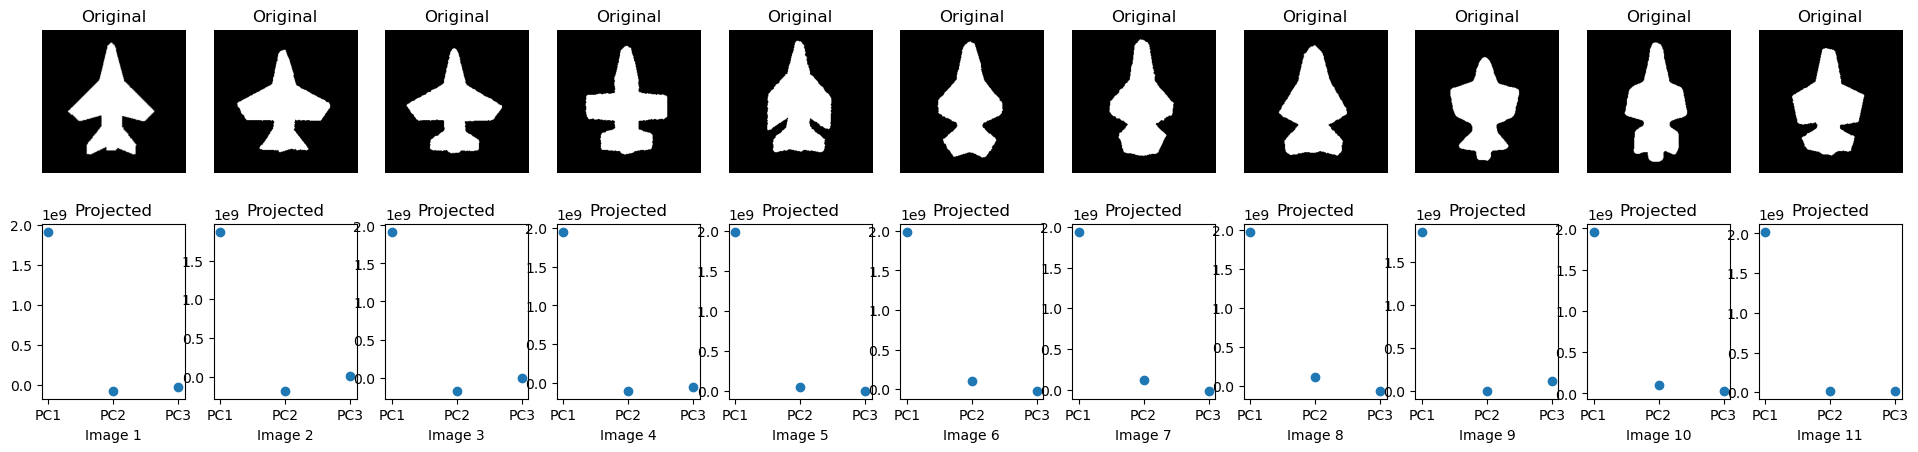

In [7]:
# Plot the result
plt.figure(figsize=(24, 5))
for i in range(11):
    plt.subplot(2, 11, i + 1)
    plt.imshow(image_data[i].reshape(256, 256), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, 11, i + 12)
    plt.scatter(range(3), projected_images[:, i])
    plt.title("Projected")
    plt.xticks(range(3), ['PC1', 'PC2', 'PC3'])
    plt.xlabel("Image " + str(i + 1))

plt.show()

This code creates a scree plot, illustrating the eigenvalues of principal components.

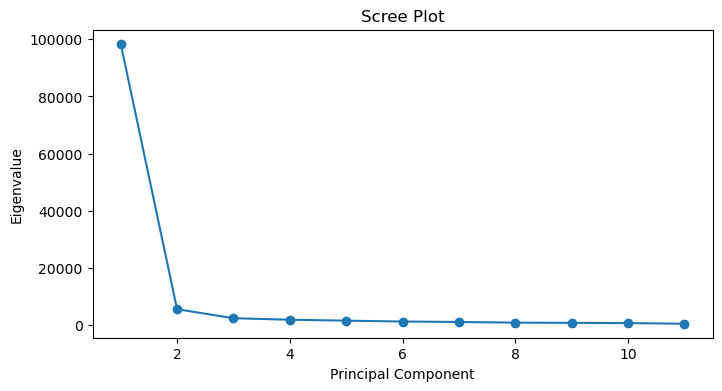

In [8]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(sorted_eigenvalues) + 1), sorted_eigenvalues, marker='o', linestyle='-')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.show()

This code generates a plot depicting the cumulative variance explained by an increasing number of principal components.

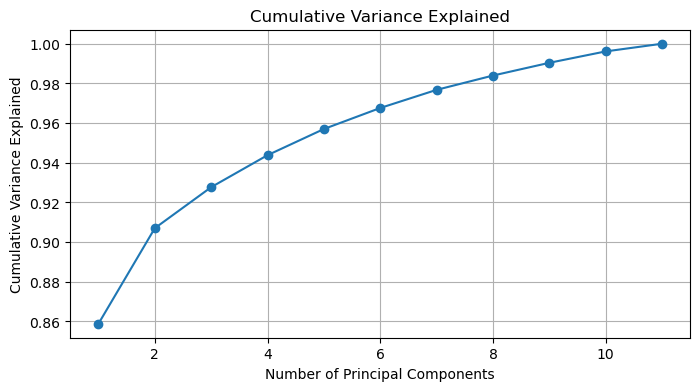

In [9]:
cumulative_variance = np.cumsum(sorted_eigenvalues) / np.sum(sorted_eigenvalues)
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(sorted_eigenvalues) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained')
plt.grid()
plt.show()

This code creates a 3D scatter plot using the first three principal components, with PC1, PC2, and PC3 represented on the x, y, and z axes, respectively.

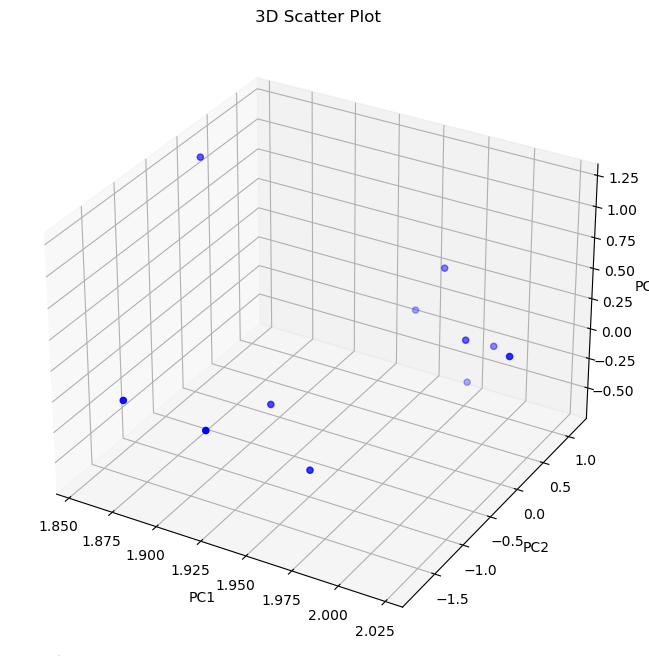

In [10]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(projected_images[0, :], projected_images[1, :], projected_images[2, :], c='b', marker='o')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('3D Scatter Plot')
plt.show()

## PART 2: Image Retrieval

**Calculating the feature vectors of the image**

This function calculates the color histogram of an input image. If specified as HSV, the image is converted to the HSV color space. The image values are normalized to the range [0, 255], and a histogram is computed using the specified number of bins. The resulting histogram vector is normalized to have unit area and then returned.

In [11]:
def calculate_color_histogram(image, is_hsv, bins=(16, 16, 16)):
    if is_hsv:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        
    # Normalize image values to [0, 255]
    image = (image * 255).astype(np.uint8)

    bin_indices = (image[:, :, 0] * bins[1] * bins[0] + image[:, :, 1] * bins[0] + image[:, :, 2]) // 8
    bin_indices = np.clip(bin_indices, 0, np.prod(bins) - 1)

    hist_vector = np.bincount(bin_indices.flatten(), minlength=np.prod(bins))

    # Normalize the histogram to have unit area
    hist_vector = hist_vector.astype(np.float32) / np.sum(hist_vector)
    return hist_vector


This function calculates color histograms for images in each class within a specified dataset folder, storing the resulting feature vectors in a dictionary.

In [12]:
def calculate_feature_vectors(dataset_folder,is_hsv,bins=(16, 16, 16)):
    class_feature_vectors = {}

    for class_folder in os.listdir(dataset_folder):
        class_path = os.path.join(dataset_folder, class_folder)
        if os.path.isdir(class_path):
            class_feature_vectors[class_folder] = []
            for filename in os.listdir(class_path):
                if filename.endswith(".jpg"):
                    image_path = os.path.join(class_path, filename)
                    img = np.array(Image.open(image_path))
                    img_rgb = img[:, :, ::-1]
                    
                    # Calculating feature vectors
                    feature_vector = calculate_color_histogram(img_rgb, is_hsv, bins)
                    class_feature_vectors[class_folder].append(feature_vector)
                    
    return class_feature_vectors

These lines of code calculate color histograms for images in each class within "Dataset2" and store the resulting feature vectors in the variable all_feature_vectors.

In [13]:
dataset_folder = "Dataset2"
all_feature_vectors  = calculate_feature_vectors(dataset_folder, False)

**Calculating distance between selected image (image’s features) and all the other images (all other images’ features)**

This function computes the Euclidean distance between two feature vectors by calculating the squared differences, summing them, and taking the square root of the result.

In [14]:
def euclidean_distance(feature_vector1, feature_vector2):
    squared_difference = np.square(feature_vector1 - feature_vector2)
    sum_squared_difference = np.sum(squared_difference)
    distance = np.sqrt(sum_squared_difference)
    return distance

**Generating a ranked list based on the distance between them**

This function generates a ranked list based on the input distances, sorting the indices in ascending order of their corresponding distance values.

In [15]:
def generate_ranked_list(distances):
    ranked_list = sorted(range(len(distances)), key=lambda k: distances[k])
    return ranked_list

This function compiles feature vectors for all images in the dataset, generates ranked lists based on their Euclidean distances, and returns a dictionary containing the feature vectors for each image.

In [16]:
def all_images_ranked_list():
    all_images_feature_vectors = {}
    count = 0
    for class_name in all_feature_vectors:
        for i in range(len(all_feature_vectors[class_name])):
            all_images_feature_vectors[count+i] = all_feature_vectors[class_name][i]
        if count < 270:
            count += 30
        else:
            break
            
    # Dictionary to store ranked lists for each image        
    ranked_lists = {}  
    for class_name, class_feature_vector in all_images_feature_vectors.items():
        distances = [euclidean_distance(class_feature_vector, feature_vector) for feature_vector in all_images_feature_vectors.values()]
        ranked_list = generate_ranked_list(distances)
        ranked_lists[class_name] = ranked_list
    
    return all_images_feature_vectors

This function generates ranked lists for query images based on their Euclidean distances from the feature vectors of all images in the dataset. The resulting ranked lists are stored in a dictionary.

In [17]:
def create_query_images_ranked_lists(all_images_feature_vectors):
    count = 0
    
    # Dictionary to store ranked lists of query images
    query_images_ranked_lists = {}  
    for query_image in all_feature_vectors["QUERY_IMAGES"]:
        distances = [euclidean_distance(query_image, feature_vector) for feature_vector in all_images_feature_vectors.values()]
        ranked_list = generate_ranked_list(distances)
        query_images_ranked_lists[count] = ranked_list
        count += 1
    return query_images_ranked_lists

This function maps a given array of image indices to their corresponding class names based on predefined index ranges for different classes.

In [18]:
def change_index_to_class_name(arr):
    class_names = []
    for image_index in arr:
        class_name = ""
        if 0<= image_index<30:
            class_name = "airplane"
        elif 30<= image_index<60:
            class_name = "bear"
        elif 60<= image_index<90:
            class_name = "blimp"
        elif 90<= image_index<120:
            class_name = "bonsai"
        elif 120<= image_index<150:
            class_name = "cactus"
        elif 150<= image_index<180:
            class_name = "dog"
        elif 180<= image_index<210:
            class_name = "goat"
        elif 210<= image_index<240:
            class_name = "goose"
        elif 240<= image_index<270:
            class_name = "ibis"
        elif 270<= image_index<300:
            class_name = "iris"
        class_names.append(class_name)
    return class_names

This function displays the most similar images for a given query index from the ranked lists. It prints the similar image indexes and their corresponding class names.

In [19]:
def show_most_similar_images(query_index, ranked_lists, num_similar=10):
    if query_index in ranked_lists:
        similar_images = ranked_lists[query_index][:num_similar]
        class_names = change_index_to_class_name(similar_images)
        image_indexes = similar_images
        print(f"Most similar images for query {query_index}:")
        print("Similar image indexes: ",image_indexes)
        print("Similar image class names: ",class_names)
        return class_names

This function updates the keys in the query_images_ranked_lists dictionary by renaming them to match the new format. Each key is replaced with a combination of the class name and a numeric identifier.

In [20]:
def update_query_images_ranked_lists():
    query_images_ranked_lists["airplane-1"] = query_images_ranked_lists.pop(0)
    query_images_ranked_lists["airplane-2"] = query_images_ranked_lists.pop(1)
    query_images_ranked_lists["bear-1"] = query_images_ranked_lists.pop(2)
    query_images_ranked_lists["bear-2"] = query_images_ranked_lists.pop(3)
    query_images_ranked_lists["blimp-1"] = query_images_ranked_lists.pop(4)
    query_images_ranked_lists["blimp-2"] = query_images_ranked_lists.pop(5)
    query_images_ranked_lists["bonsai-1"] = query_images_ranked_lists.pop(6)
    query_images_ranked_lists["bonsai-2"] = query_images_ranked_lists.pop(7)
    query_images_ranked_lists["cactus-1"] = query_images_ranked_lists.pop(8)
    query_images_ranked_lists["cactus-2"] = query_images_ranked_lists.pop(9)
    query_images_ranked_lists["dog-1"] = query_images_ranked_lists.pop(10)
    query_images_ranked_lists["dog-2"] = query_images_ranked_lists.pop(11)
    query_images_ranked_lists["goat-1"] = query_images_ranked_lists.pop(12)
    query_images_ranked_lists["goat-2"] = query_images_ranked_lists.pop(13)
    query_images_ranked_lists["goose-1"] = query_images_ranked_lists.pop(14)
    query_images_ranked_lists["goose-2"] = query_images_ranked_lists.pop(15)
    query_images_ranked_lists["ibis-1"] = query_images_ranked_lists.pop(16)
    query_images_ranked_lists["ibis-2"] = query_images_ranked_lists.pop(17)
    query_images_ranked_lists["iris-1"] = query_images_ranked_lists.pop(18)
    query_images_ranked_lists["iris-2"] = query_images_ranked_lists.pop(19)

In [21]:
# All images feature vectors except for the query images
all_images_feature_vectors = all_images_ranked_list()
query_images_ranked_lists = create_query_images_ranked_lists(all_images_feature_vectors)
update_query_images_ranked_lists()

### Show 10 most similar images

In [22]:
for i in query_images_ranked_lists.keys():
    show_most_similar_images(i, query_images_ranked_lists)

Most similar images for query airplane-1:
Similar image indexes:  [11, 19, 28, 9, 7, 165, 12, 15, 20, 10]
Similar image class names:  ['airplane', 'airplane', 'airplane', 'airplane', 'airplane', 'dog', 'airplane', 'airplane', 'airplane', 'airplane']
Most similar images for query airplane-2:
Similar image indexes:  [7, 255, 159, 10, 165, 201, 205, 177, 198, 161]
Similar image class names:  ['airplane', 'ibis', 'dog', 'airplane', 'dog', 'goat', 'goat', 'dog', 'goat', 'dog']
Most similar images for query bear-1:
Similar image indexes:  [285, 276, 100, 37, 214, 146, 231, 56, 39, 176]
Similar image class names:  ['iris', 'iris', 'bonsai', 'bear', 'goose', 'cactus', 'goose', 'bear', 'bear', 'dog']
Most similar images for query bear-2:
Similar image indexes:  [259, 128, 258, 292, 176, 145, 269, 214, 189, 100]
Similar image class names:  ['ibis', 'cactus', 'ibis', 'iris', 'dog', 'cactus', 'ibis', 'goose', 'goat', 'bonsai']
Most similar images for query blimp-1:
Similar image indexes:  [92, 72,

**Evaluating results via mean average precision (MAP) metric**

This function calculates the average precision for a given actual class and its ranked list by iterating through the ranks, incrementing the relevant count, and computing precision values at each relevant image. The average precision is the mean of these precision values.

In [23]:
def calculate_precision(actual_class,rank_list):
    relevant_count = 0 
    precision_values = []
    # start with rank (K) 1
    for i in range(1,len(rank_list)):
        # if the image at rank K is relevant
        if rank_list[i] == actual_class:
            relevant_count += 1
            precision_value = relevant_count / i
            precision_values.append(precision_value)
    # take the average of all precision values at all relevant images
    avg_precision = sum(precision_values) / len(precision_values)
    return avg_precision

This function calculates the mean average precision for each class in the query images, considering the precision values from their respective ranked lists. The results are stored in a dictionary named query_class_mean_precision.

In [24]:
def calculate_query_class_mean_precision(query_images_ranked_lists):
    query_class_mean_precision = {}
    avg_precision_values = [calculate_precision(key.split('-')[0],value) for key,value in query_images_ranked_lists.items()]
    query_class_mean_precision["airplane"] = (avg_precision_values[0] + avg_precision_values[1]) / 2
    query_class_mean_precision["bear"] = (avg_precision_values[2] + avg_precision_values[3]) / 2
    query_class_mean_precision["blimp"] = (avg_precision_values[4] + avg_precision_values[5]) / 2
    query_class_mean_precision["bonsai"] = (avg_precision_values[6] + avg_precision_values[7]) / 2
    query_class_mean_precision["cactus"] = (avg_precision_values[8] + avg_precision_values[9]) / 2
    query_class_mean_precision["dog"] = (avg_precision_values[10] + avg_precision_values[11]) / 2
    query_class_mean_precision["goat"] = (avg_precision_values[12] + avg_precision_values[13]) / 2
    query_class_mean_precision["goose"] = (avg_precision_values[14] + avg_precision_values[15]) / 2
    query_class_mean_precision["ibis"] = (avg_precision_values[16] + avg_precision_values[17]) / 2
    query_class_mean_precision["iris"] = (avg_precision_values[18] + avg_precision_values[19]) / 2
    return query_class_mean_precision

This code updates the class names in query_images_ranked_lists and calculates the mean average precision for each class.

In [25]:
for key,feature_vector in query_images_ranked_lists.items():
    query_images_ranked_lists[key] = change_index_to_class_name(feature_vector)
    
calculate_query_class_mean_precision(query_images_ranked_lists)

{'airplane': 0.2869518062382494,
 'bear': 0.1606542681194612,
 'blimp': 0.1093017270246634,
 'bonsai': 0.09602646309840132,
 'cactus': 0.13136428393272487,
 'dog': 0.11425452554053389,
 'goat': 0.14340625257878006,
 'goose': 0.14348362862514052,
 'ibis': 0.11920434852510932,
 'iris': 0.2135756940334287}

**Use k-means algorithm to cluster the images**

This function performs K-Means clustering on all feature vectors, visualizing the results using t-SNE with a scatter plot. The number of clusters is set to 10, and the visualized data is displayed.

In [26]:
def k_means(all_feature_vectors):
    num_clusters = 10  # Adjust as needed
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    all_feature_vectors_flat = np.vstack([class_vectors for class_vectors in all_feature_vectors.values()])
    cluster_labels = kmeans.fit_predict(all_feature_vectors_flat)
    tsne = TSNE(n_components=2, random_state=42)
    visualized_data = tsne.fit_transform(all_feature_vectors_flat)
    plt.scatter(visualized_data[:, 0], visualized_data[:, 1], c=cluster_labels, cmap='tab10')
    plt.title('t-SNE Visualization of K-Means Clustering')
    plt.show()

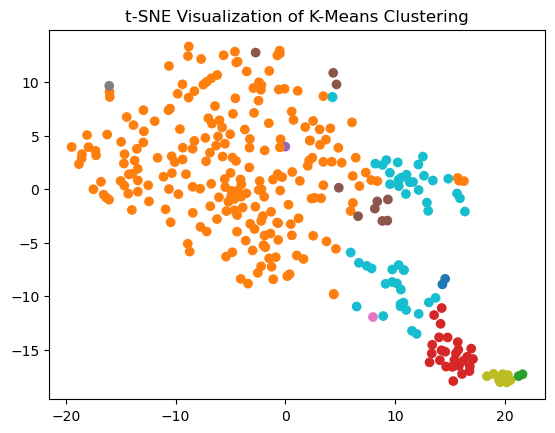

In [27]:
k_means(all_feature_vectors)

#### Different Color Spaces for Color Histogram: HSV

Same process applied for HSV color space

In [28]:
all_feature_vectors  = calculate_feature_vectors(dataset_folder, True)
all_images_feature_vectors = all_images_ranked_list()
query_images_ranked_lists = create_query_images_ranked_lists(all_images_feature_vectors)
update_query_images_ranked_lists()
for i in query_images_ranked_lists.keys():
    show_most_similar_images(i, query_images_ranked_lists)

Most similar images for query airplane-1:
Similar image indexes:  [11, 10, 109, 51, 166, 20, 6, 76, 208, 24]
Similar image class names:  ['airplane', 'airplane', 'bonsai', 'bear', 'dog', 'airplane', 'airplane', 'blimp', 'goat', 'airplane']
Most similar images for query airplane-2:
Similar image indexes:  [7, 108, 297, 210, 86, 107, 240, 201, 161, 239]
Similar image class names:  ['airplane', 'bonsai', 'iris', 'goose', 'blimp', 'bonsai', 'ibis', 'goat', 'dog', 'goose']
Most similar images for query bear-1:
Similar image indexes:  [56, 182, 142, 197, 190, 123, 138, 126, 227, 233]
Similar image class names:  ['bear', 'goat', 'cactus', 'goat', 'goat', 'cactus', 'cactus', 'cactus', 'goose', 'goose']
Most similar images for query bear-2:
Similar image indexes:  [267, 296, 279, 186, 181, 145, 129, 216, 273, 182]
Similar image class names:  ['ibis', 'iris', 'iris', 'goat', 'goat', 'cactus', 'cactus', 'goose', 'iris', 'goat']
Most similar images for query blimp-1:
Similar image indexes:  [156, 

In [29]:
for key, feature_vector in query_images_ranked_lists.items():
    query_images_ranked_lists[key] = change_index_to_class_name(feature_vector)
calculate_query_class_mean_precision(query_images_ranked_lists)

{'airplane': 0.20663481902576908,
 'bear': 0.14038435663603888,
 'blimp': 0.08535154617696886,
 'bonsai': 0.10151458354350507,
 'cactus': 0.14579976033319014,
 'dog': 0.08605909601636416,
 'goat': 0.15155763813586656,
 'goose': 0.15884588340856864,
 'ibis': 0.10828250353911775,
 'iris': 0.18493117781611654}

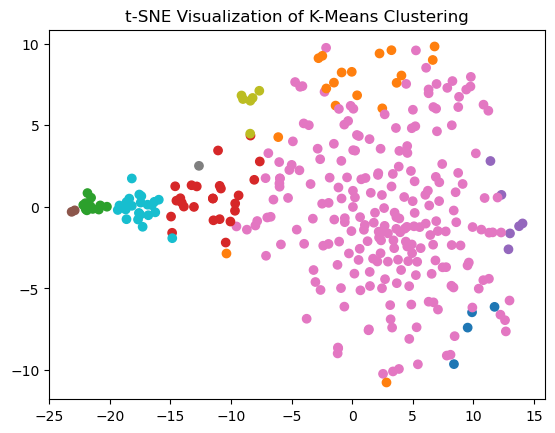

In [30]:
k_means(all_feature_vectors)

## PART 3: Classification

This function loads and preprocesses images from a specified folder path. It flattens the images, assigns labels based on class folders, and resizes them to the target size.

In [31]:
def load_images(folder_path, target_size=(100, 100)):
    train_images, train_labels, test_images, test_labels = [], [], [], []
    class_to_label = {class_name: label for label, class_name in enumerate(os.listdir(folder_path))}
    
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)
            img = Image.open(image_path).resize(target_size)
            img = np.array(img)
            if class_folder != "QUERY_IMAGES":
                train_images.append(img.flatten())
                train_labels.append(class_to_label[class_folder])
            else:
                # changing file name
                if filename.split('_')[0] == "goose":
                    filename = "googse"
                test_images.append(img.flatten())
                test_labels.append(class_to_label[filename.split('_')[0]])

    return np.array(train_images), np.array(train_labels), np.array(test_images), np.array(test_labels)

These lines load and preprocess images from the "Dataset2" folder, resulting in arrays for training and test images (train_images, test_images) and their respective labels (train_labels, test_labels). Images are resized to 128x128 pixels.

In [32]:
dataset_path = "Dataset2"
train_images, train_labels, test_images, test_labels = load_images(dataset_path, target_size=(128, 128))

In [33]:
print("x train: ",train_images.shape)
print("x test: ",test_images.shape)
print("y train: ",train_labels.shape)
print("y test: ",test_labels.shape)

x train:  (300, 49152)
x test:  (20, 49152)
y train:  (300,)
y test:  (20,)


This class implements logistic regression with gradient descent. It includes methods for sigmoid activation, parameter initialization, cost computation, training, and prediction.

In [34]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def initialize_params(self, num_features):
        self.weights = np.zeros((num_features, 1))
        self.bias = 0

    def compute_cost(self, y, y_pred):
        m = len(y)
        cost = (-1/m) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        return cost

    def train(self, X, y):
        num_samples, num_features= X.shape
        self.weights = np.zeros((num_features, 1))
        self.bias = 0.0

        for iteration in range(self.num_iterations):
            z =(np.dot(X, self.weights)) + self.bias
            predictions = self.sigmoid(z)
            dz = predictions - y.reshape(-1, 1)
            dw = (1/num_samples) * np.dot(X.T, dz)
            db = (1/num_samples) * np.sum(dz)
            # Compute gradients
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(z)
        return (y_pred >= 0.5).astype(int)

This function trains one-versus-rest (OvR) logistic regression models for each unique class in the training labels. It creates a binary label for each class, trains a logistic regression model for that class, and stores the models in a dictionary.

In [35]:
def train_ovr_models(X_train, y_train):
    unique_classes = np.unique(y_train)
    models = {}

    for class_name in unique_classes:
        binary_labels = (y_train == class_name).astype(int)
        model = LogisticRegression()
        model.train(X_train, binary_labels)
        models[class_name] = model

    return models

#### Classifying all of the classes

In [36]:
models = train_ovr_models(train_images, train_labels)

In [37]:
predictions = {}
for class_name, model in models.items():
    pred_labels = model.predict(test_images)
    predictions[class_name] = pred_labels

In [38]:
for class_name, pred_labels in predictions.items():
    print(f"Class: {class_name}, Predictions: {pred_labels}")

Class: 0, Predictions: [[1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
Class: 1, Predictions: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
Class: 2, Predictions: [[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
Class: 3, Predictions: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]
Class: 4, Predictions: [[0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]]
Class: 5, Predictions: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
Class: 6, Predictions: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]]
Class: 7, Predictions: [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]]
Class: 8

This function calculates the accuracy of a set of predictions by comparing them to the true labels for each class and then averaging the correct predictions over the total number of samples.

In [39]:
def calculate_accuracy(predictions, true_labels):
    correct_predictions = 0
    acc_per_class = {}
    for class_name, pred_labels in predictions.items():
        correct_predictions += np.sum(pred_labels == true_labels[class_name])
        acc_per_class[class_name] = np.sum(pred_labels == true_labels[class_name]) / 20
    accuracy = correct_predictions / 200
    return accuracy, acc_per_class

In [40]:
accuracy,acc_per_class = calculate_accuracy(predictions, test_labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.19


In [41]:
for class_name, acc in acc_per_class.items():
    print("Accuracy of class: ", class_name ,"is" ,+ acc )

Accuracy of class:  0 is 0.8
Accuracy of class:  1 is 0.95
Accuracy of class:  2 is 0.1
Accuracy of class:  3 is 0.05
Accuracy of class:  4 is 0.0
Accuracy of class:  5 is 0.0
Accuracy of class:  6 is 0.0
Accuracy of class:  7 is 0.0
Accuracy of class:  8 is 0.0
Accuracy of class:  9 is 0.0


In [42]:
def calculate_precision(predictions, true_labels):
    precision_per_class = {}

    for class_name, pred_labels in predictions.items():
        true_positives = np.sum((pred_labels == 1) & (true_labels[class_name] == 1))
        false_positives = np.sum((pred_labels == 1) & (true_labels[class_name] == 0))

        if true_positives + false_positives == 0:
            precision_per_class[class_name] = 0
        else:
            precision_per_class[class_name] = true_positives / (true_positives + false_positives)

    overall_precision = sum(precision_per_class.values()) / len(precision_per_class)

    return overall_precision, precision_per_class

In [43]:
def calculate_recall(predictions, true_labels):
    recall_per_class = {}

    for class_name, pred_labels in predictions.items():
        true_positives = np.sum((pred_labels == 1) & (true_labels[class_name] == 1))
        false_negatives = np.sum((pred_labels == 0) & (true_labels[class_name] == 1))

        if true_positives + false_negatives == 0:
            recall_per_class[class_name] = 0
        else:
            recall_per_class[class_name] = true_positives / (true_positives + false_negatives)

    overall_recall = sum(recall_per_class.values()) / len(recall_per_class)

    return overall_recall, recall_per_class

In [44]:
precision,precision_per_class = calculate_precision(predictions, test_labels)
print(f"Precision: {precision}")

Precision: 0.2


In [45]:
for class_name, precision in precision_per_class.items():
    print("Accuracy of class: ", class_name ,"is" ,+ precision)

Accuracy of class:  0 is 0.0
Accuracy of class:  1 is 0.0
Accuracy of class:  2 is 1.0
Accuracy of class:  3 is 1.0
Accuracy of class:  4 is 0
Accuracy of class:  5 is 0
Accuracy of class:  6 is 0
Accuracy of class:  7 is 0
Accuracy of class:  8 is 0
Accuracy of class:  9 is 0


In [46]:
recall,recall_per_class = calculate_recall(predictions, test_labels)
print(f"Precision: {precision}")

Precision: 0


In [47]:
for class_name, recall in recall_per_class.items():
    print("Accuracy of class: ", class_name ,"is" ,+ recall)

Accuracy of class:  0 is 0
Accuracy of class:  1 is 0
Accuracy of class:  2 is 0.1
Accuracy of class:  3 is 0.05
Accuracy of class:  4 is 0
Accuracy of class:  5 is 0
Accuracy of class:  6 is 0
Accuracy of class:  7 is 0
Accuracy of class:  8 is 0
Accuracy of class:  9 is 0
